In [1]:
from IPython.display import Image
import networkx as nx
from typing import List, Dict, Iterable, Tuple
import copy

## Brujin graphs from repeat_spectra

In [2]:
def suffix(string):
    return string[1:]
def prefix(string):
    return string[0:len(string)-1]

In [3]:
def de_bruijn_kmers(k_mers):
    # Get the prefixes and suffixes. 
    prefixes = []
    suffixes = []
    for i in k_mers:
        prefixes.append(prefix(i))
        suffixes.append((suffix(i), k_mers[i]))
    
    # Build up the Debrujin
    brujin = {}
    for i, pref in enumerate(prefixes):
        if pref in list(brujin.keys()):
            brujin[pref].append(suffixes[i])
        else:
            brujin.update({pref:[suffixes[i]]})

    return(brujin)

## String to multiset

In [7]:
def to_kmers(string, k):
    k_mers = {}
    for i in range(0, len(string) -k + 1):
        window = string[i:i+k]
        if window in k_mers.keys():
            k_mers[window] += 1
        else:
            k_mers[window] = 1
    return k_mers

## Union graph

In [169]:
### Bubble:
# string_1 = "ACGTACAT"
# string_2 = "ACGTAGAT"

### Looper:
#string_1 = "AAAAA"
#string_2 = "AACAA"

### Split:
# string_1 = "ACGTACAT"
# string_2 = "ACGTACAG"

### Two snps right next to each other (big bubble). 
# string_1 = "ACGTACAT"
# string_2 = "ACGGCCAT"

###!!!### Some weird looking stuff with two snps. 
# string_1 = "ACGTACAT"
# string_2 = "ACGGAGAT"

### This has a repeated section in it TACATACA and 1 snp. 
# string_1 = "ACGTACATACA"
# string_2 = "ACGTAGATACA"

###!!!### The palindromic example
# string_1 = "ACGTAGATGCA"
# string_2 = "ACGCAGATACA"

### Highly disconnected graph. 
# string_1 = "AAAAC"
# string_2 = "AACAC"

# string_1 = "AAAAG"
# string_2 = "AACAG"

### The reverse split.
# string_1 = "CGTAC"
# string_2 = "AGTAC"

# string_1 = "AAAAA"
# string_2 = "AACAA"

string_1 = "AACACCAACCCAAAACCCAACAC"
string_2 = "AACACCAACACAAAACCCAACAC"

In [202]:
def union_graph(db1,db2):
    union = {}
    purple = {}
    all_keys = set(list(db1.keys()) + list(db2.keys()))
    for key in all_keys:
        # Makes sure the key is already in union. 
        try:
            blank = union[key]
        except:
            union[key] = []
            purple[key] = set()
    
        # Checks to see if this key is present in the first De-bruijn, and if not 
        # adds the information at that key to the union graph
        try:
            x = db1[key]
        except:
            for j in db2[key]:
                union[key].append((j[0],-1*j[1]))
            continue
    
        # Checks to see if this key is present in the second De-bruijn, and if not 
        # adds the information at that key to the union graph
        try:
            y = db2[key]
        except:
            for i in db1[key]:
                union[key].append((i))
            continue
    
        ###!!!### This is definitely a bit slow, but it is the only way to ensure that it works perfectly right now. 
        for i in db1[key]:
            if i[0] not in [z[0] for z in db2[key]]:
                union[key].append((i[0],i[1]))
            if i in db2[key]:
                purple[key].add(i[0])
                
        for j in db2[key]:
            if j[0] not in [z[0] for z in db1[key]]:
                union[key].append((j[0],-1*j[1]))
            if j in db1[key]:
                purple[key].add(j[0])
        
        for i in db1[key]:
            for j in db2[key]:
                if i[0] == j[0]:
                    if i[1] != j[1]:
                        union[key].append((i[0], i[1] - j[1]))
                        
        if len(purple[key]) == 0:
            del purple[key]
        if len(union[key]) == 0:
            del union[key]
    return (union,purple)

## Fixing the incomplete edges problem. 

In [203]:
def reverse_union_graph(union):
    reverse_union = {}
    for i in union:
        for j in union[i]:
            try:
                reverse_union[j[0]].append((i,j[1]))
            except:
                reverse_union[j[0]] = [(i,j[1])]
    return reverse_union

In [204]:
def wallbreak(infront, wall, behind, G, sign):
    G[infront].remove((wall, sign))
    try:
        G[behind].append((wall, sign))
    except:
        G[behind] = []
        G[behind].append((wall, sign))

In [206]:
def incomplete_edge_adjustment(union, purple):
    reverse_union = reverse_union_graph(union)
    for i, j in purple.items():
        for k in j:
            try:
                blank = union[k]
            except:
                continue
            if len(union[k]) == 1:
                try:
                    infront, sign = reverse_union[k][0]
                except:
                    continue
                wallbreak(infront, k, i, union, sign)
                            
    union= {key:value for key,value in union.items() if value}
    return union

## Hyrum's functions:

In [228]:
#balanced is defined as having at least 1 red and blue outgoing edges
def is_source(node: str, G: Dict):
    edges = G[node]
    red = False
    blue = False
    for edge in edges:
        if edge[1] < 0:
            red = True
        elif edge[1] > 0:
            blue = True
    if red and blue:
        return True

def get_next_red_node(source, G):
    edges = G[source]
    candidate_nodes = []
    ###!!!### Need to add in loop priority here. 
    for edge in edges:
        if edge[1] > 0:
            candidate_nodes.append(edge[0])
    if source in candidate_nodes:
        next_node = copy.copy(source)
    else:
        next_node = candidate_nodes[0]
    for i in range(0, len(edges)):
        edge = edges[i]
        node = edge[0]
        if edge[0] == next_node and edge[1] > 0:
            edge_count = edge[1] - 1
            del edges[i]
            if len(edges) == 0:
                del G[source]
            if edge_count != 0:
                edges.append((node, edge_count))
            break
    return next_node

def get_next_blue_node(source, G):
    edges = G[source]
    candidate_nodes = []
    for edge in edges:
        if edge[1] < 0:
            candidate_nodes.append(edge[0])
    ####this will have to change once we decide on how to resolve multiple edges
    if source in candidate_nodes:
        next_node = copy.copy(source)
    else:
        next_node = candidate_nodes[0]
    for i in range(0, len(edges)):
        edge = edges[i]
        node = edge[0]
        if edge[0] == next_node and edge[1] < 0:
            edge_count = edge[1] + 1
            del edges[i]
            if len(edges) == 0:
                del G[source]
            if edge_count != 0:
                edges.append((node, edge_count))
            break
    return next_node

def resolve_bubble(source: str, G:Dict, k:int):
    '''
    iterate through source edges and assign 'starts' to red and blue branches. 
    will have to update to account for more than 2 outgoing (edge-picking)
    convention for this alg: red->positive, blue->negative
    '''
    print(source)
    print(G)
    next_red_node = get_next_red_node(source, G)
    #print(G)
    next_blue_node = get_next_blue_node(source,G)
    #print(G)
    edit_count = 0
    node_l = k - 1
    change_tracker = ['' for i in range(node_l)]

    while True:
        print('R: ' + next_red_node)
        print('B: ' + next_blue_node + '\n')

        for i in range(0, node_l):
            #python strings are immutable, have to make them lists
            red_str_list = list(next_red_node)
            blue_str_list = list(next_blue_node)

            #by convention red is the 'correct' string
            if change_tracker[i] != '':
                blue_str_list[i] = change_tracker[i]

            if blue_str_list[i] == red_str_list[i]:
                continue
            else:
                blue_str_list[i] = red_str_list[i]
                change_tracker[i] = red_str_list[i]
                edit_count += 1
        #shift the change tracker before moving to next nodes
        del change_tracker[0]
        change_tracker.append('')

        #stop if either blue or red doesnt have contiuation
        if next_blue_node not in G or next_red_node not in G:
            #print(change_tracker)
            return edit_count

        next_red_node = get_next_red_node(next_red_node, G)
        next_blue_node = get_next_blue_node(next_blue_node, G)

def transform_graph(union: Dict, k:int):
    sources = []
    for key in union:
        if is_source(key, union):
            sources.append(key)
    print(sources)

    total_edits = 0
    #loop will continue while there are sources and eges in dict
    while len(sources) != 0 and len(union) > 0:
        count = 0
        current_source = sources[0]
        try:
            count = resolve_bubble(current_source, union, k)
        except:
            print("what")
        total_edits += count
        del sources[0]

    return total_edits

## Examples

In [266]:
### Bubble:
# string_1 = "ACGTACAT"
# string_2 = "ACGTAGAT"

### Looper:
# string_1 = "AAAAA"
# string_2 = "AACAA"

### Split:
# string_1 = "ACGTACAT"
# string_2 = "ACGTACAG"

### Two snps right next to each other (big bubble). 
# string_1 = "ACGTACAT"
# string_2 = "ACGGCCAT"

###!!!### Some weird looking stuff with two snps. 
# string_1 = "ACGTACAT"
# string_2 = "ACGGAGAT"

### This has a repeated section in it TACATACA and 1 snp. 
# string_1 = "ACGTACATACA"
# string_2 = "ACGTAGATACA"

###!!!### The palindromic example
# string_1 = "ACGTAGATGCA"
# string_2 = "ACGCAGATACA"

### Highly disconnected graph. 
# string_1 = "AAAAC"
# string_2 = "AACAC"

# string_1 = "AAAAG"
# string_2 = "AACAG"

### The reverse split.
# string_1 = "CGTAC"
# string_2 = "AGTAC"

# string_1 = "AAAAA"
# string_2 = "AACAA"

# string_1 = "AACACCAACCCAAAACCCAACAC"
# string_2 = "AACACCAACACAAAACCCAACAC"

In [267]:
# Creating the initial De-Bruijn Graph
repeat_1 = to_kmers(string_1, 3)
repeat_2 = to_kmers(string_2, 3)
db1 = de_bruijn_kmers(repeat_1)
db2 = de_bruijn_kmers(repeat_2)

In [268]:
union, purple = union_graph(db1, db2)
union = incomplete_edge_adjustment(union, purple)
transform_graph(union, 3)

['AC']
AC
{'CA': [('AC', -1)], 'AC': [('CA', -2), ('CC', 1)], 'CC': [('CA', 1), ('CC', 1)]}
R: CC
B: CA

R: CC
B: AC



1

## Visualization

In [167]:
G = nx.MultiDiGraph()
edge_list = []
for i in union:
    for j in union[i]:
        edge_list.append((i, j[0], {'label':j[1]}))

G.add_edges_from(edge_list)
D = nx.drawing.nx_agraph.to_agraph(G)
D.node_attr.update(color='blue', style='filled', fillcolor='white')
D.edge_attr.update(color='blue', arrowsize=1)
pos = D.layout('dot')
D.draw("union_graph.jpg")

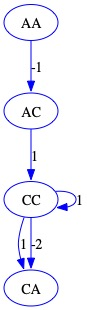

In [168]:
Image(filename='union_graph.jpg') 

## Visualization 2

In [21]:
G = nx.MultiDiGraph()
edge_list = []
for i in db1:
    for j in db1[i]:
        edge_list.append((i, j[0], {'label':j[1]}))

G.add_edges_from(edge_list)
D = nx.drawing.nx_agraph.to_agraph(G)
D.node_attr.update(color='blue', style='filled', fillcolor='white')
D.edge_attr.update(color='blue', arrowsize=1)
pos = D.layout('dot')
D.draw("db1_graph.jpg")

G = nx.MultiDiGraph()
edge_list = []
for i in db2:
    for j in db2[i]:
        edge_list.append((i, j[0], {'label':j[1]}))

G.add_edges_from(edge_list)
D = nx.drawing.nx_agraph.to_agraph(G)
D.node_attr.update(color='blue', style='filled', fillcolor='white')
D.edge_attr.update(color='blue', arrowsize=1)
pos = D.layout('dot')
D.draw("db2_graph.jpg")

In [22]:
full = {}
for i in db1:
    try:
        y = full[i]
    except:
        full[i] = []
    try:
        x = db2[i]
        for j in db1[i]:
            full[i].append((j))
    except:
        full[i] = []
        for j in db1[i]:
            full[i].append((j))
            
for i in db2:
    try:
        y = full[i]
    except:
        full[i] = []
    try:
        x = db1[i]
        for j in db2[i]:
                full[i].append((j[0],-1*j[1]))
    except:
        union[i] = []
        for j in db2[i]:
            full[i].append((j[0],-1*j[1]))

In [23]:
G = nx.MultiDiGraph()
edge_list = []
for i in full:
    for j in full[i]:
        edge_list.append((i, j[0], {'label':j[1]}))

G.add_edges_from(edge_list)
D = nx.drawing.nx_agraph.to_agraph(G)
D.node_attr.update(color='blue', style='filled', fillcolor='white')
D.edge_attr.update(color='blue', arrowsize=1)
pos = D.layout('dot')
D.draw("full_graph_new.jpg")

In [24]:
x = set()